# Creación de modelos de puntuación del Riesgo de Impago

En esta aplicación implementaremos un modelo de puntuación de riesgo de impago siguiendo la metodología  que hemos analizado en la presentación de clase (selección de variables mediante valor de la información, tramificación de variables continuas, agrupación de categorías, transformación woe de variables, estimación de modelos de regresión logística, ....)

La librería `scorecardpy` [librería scorecardpy](https://pypi.org/project/scorecardpy/)  estima tarjetas de puntuación *lineales* utilizando regresiones logísticas. Lamentablemente la versión Python de la librería da algunos errores de adaptación a las últimas versiones de Python. Su desarrollador remite a utilizar la versión estable de R (librería en R 'scorecard').

En lugar de esta librería utilizaremos la librería `optBinning` [librería OptBinning](http://gnpalencia.org/optbinning/) que en realidad recoge (y posiblemente mejor) la principal función de la librería `scorecardpy`  

## Creación de un entorno e instalación de librerías 



In [1]:
# Podemos Crear un nuevo entorno de trabajo (mejor desde el terminal)
#! conda create -n risk_env
#! conda activate risk_env
#! conda config --env --add channels conda-forge
#! conda config --env --set channel_priority strict

# Instalamos la librería pandas y seaborn en el nuevo entrono desde conda (sólo la primera vez, utilizaré el terminal (con jupiter debo utilizar !))
# conda install pandas
# conda install seaborn

# Instalamos la librería optbinning y scorecardpy (sólo la primera vez)
# ! pip install scorecardpy
# ! pip install optbinning


#Cargo oimporto pandas, numpy, Matplotlib, 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para elálisis descriptivo inicial de contraste de asociación importo el test Chi2 y el anova 
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

# Cargaríamos la librería scortecardpy si fuese estable (que no lo es)
#import scorecardpy as sc


# Librería para hacer la tramificación, agrupación y transformación WOE
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks


# Scikit-learn para dividir la muestra y para estimar el modelo de regresión logística (sólo si no se quiere utilizar
# la función optbinning.scorecard que ya lo incropora)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

(CVXPY) Mar 16 02:37:43 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 16 02:37:43 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


# Preparación de los datos sobre Créditos que utilizaremos en la práctica **germancredit**
## Carga de los datos 
En nuestra práctica utilizaremos una de las bases más utilizadas en los ejemplos de Puntuación de riesgo de crédito porque fue una de las primeras en ofrecerse en abierto. Corresponden a una base de datos de créditos de un Banco Alemán, y son datos reales, aunque muy antigüos de principios de los 90. Eso significa que las magnitudes de cantidades (expresadas en Marcos Alemanes), sean de difícil interpretación para el día de hoy. Sin embargo el signo y el sentido de las variables utilizadas para predecir el riesgo de impago de los futuros clientes permanece todavía de plena utilidad.

Los datos pueden descargarse del repositorio la UCI Machine Learning Repositoy [datos de Créditos alemanes](https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)). Esta base de datos está incorporada en la librería `sorecardpy` pero mejor utilizamos el fichero original `germancredit.csv` que os he preparado yo


In [2]:
# Cargamos los datos germancredit que están precargados en la librería scorecardpy
dt=pd.read_csv('germancredit.csv')

---
---
# Descripción inicial de los datos
Vamos a hacer una descripción inicial de los datos


In [3]:
#Información del Contenido
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Unnamed: 0                                                1000 non-null   int64 
 1   status.of.existing.checking.account                       1000 non-null   object
 2   duration.in.month                                         1000 non-null   int64 
 3   credit.history                                            1000 non-null   object
 4   purpose                                                   1000 non-null   object
 5   credit.amount                                             1000 non-null   int64 
 6   savings.account.and.bonds                                 1000 non-null   object
 7   present.employment.since                                  1000 non-null   object
 8   installment.rate.in.percentag

La **variable objetivo** será `Creditability`. Las 20 restantes variables (7 numéricas y 13 categóricas) son los atributos o características observadas de esos clientes que se utilizarán para predecir la probabilidad de que los clientes cometan un impago de sis créditos, esto es, de que sean malos clientes. La descripción de estas 20 variables es la siguiente:


In [4]:
#  - Attribute 1: (qualitative) **Status of existing checking account o cuenta corriente** 
'''Saldo de la cuenta corriente'''
#   - A11 : ... < 0 DM 
#   - A12 : 0 <= ... < 200 DM 
#   - A13 : ... >= 200 DM / salary assignments for at least 1 year 
#   - A14 : no checking account 

#- Attribute 2: (numerical) **Duration in month** 
'''Duración del préstamo en meses que el cliente está pidiendo'''
#  - Attribute 3: (qualitative) **Credit history**  
#     - A30 : no credits taken/ all credits paid back duly (devueltos sin mora)
#     - A31 : all credits at this bank paid back duly 
#     - A32 : existing credits paid back duly till now 
#     - A33 : delay in paying off in the past 
#     - A34 : critical account/ other credits existing (not at this bank) 

# - Attribute 4: (qualitative) **Purpose** 
'''Para qué pide el préstamo'''
#     - A40 : car (new) 
#     - A41 : car (used)
#     - A42 : furniture/equipment
#     - A43 : radio/television
#     - A44 : domestic appliances
#     - A45 : repairs
#     - A46 : education
#     - A47 : (vacation - does not exist?)
#     - A48 : retraining
#     - A49 : business
#    - A410 : others 

# - Attribute 5: (numerical) **Credit amount** 
'''Cantidad de préstamo que pide'''

# - Attribute 6: (qualitative) **Savings account/bonds** 
'''Saldo de cuente de ahorro (Indicador de riqueza) '''
#    - A61 : ... < 100 DM
#    - A62 : 100 <= ... < 500 DM
#    - A63 : 500 <= ... < 1000 DM
#    - A64 : .. >= 1000 DM 
#    - A65 : unknown/ no savings account 

# - Attribute 7: (qualitative) **Present employment since** 
'''Tiempo en la misma empresa (Indicador de estabilidad)'''
#     - A71 : unemployed 
#     - A72 : ... < 1 year 
#     - A73 : 1 <= ... < 4 years 
#     - A74 : 4 <= ... < 7 years 
#     - A75 : .. >= 7 years 

# - Attribute 8: (numerical) **Installment rate in percentage of disposable income** 
'''Lo que tendría que devolver cada mes por el préstamo, cuánto % supone de su renta''' 
    
#  - Attribute 9: (qualitative) **Personal status and sex** 
'''Estado civil ( Pero está muy raro)'''
#     - A91 : male : divorced/separated
#     - A92 : female : divorced/separated/married
#     - A93 : male : single
#     - A94 : male : married/widowed
#     - A95 : female : single 

# - Attribute 10: (qualitative) **Other debtors / guarantors**
'''Lo pide sólo el préstamo?, con aval? '''
#    - A101 : none
#    - A102 : co-applicant
#    - A103 : guarantor 

# - Attribute 11: (numerical) **Present residence since**
'''Antiguedad en la residencia habitual (Indicador de estabilidad)'''

# - Attribute 12: (qualitative) **Property**
'''Tiene propiedades? (Indicador de riqueza)'''
#     - A121 : real estate (Inmobiliario)
#     - A122 : if not A121 : building society savings agreement/ life insurance (Sociedad)
#     - A123 : if not A121/A122 : car or other, not in attribute 6 
#     - A124 : unknown / no property 

# - Attribute 13: (numerical) **Age in years** 


# - Attribute 14: (qualitative) **Other installment plans** Otros pagos por plazos
'''Otras obligaciones de pago'''
#      - A141 : bank
#      - A142 : stores
#      - A143 : none 

# - Attribute 15: (qualitative) **Housing**
'''Vivienda en alquiler, propiedad o cedida '''
#      - A151 : rent 
#      - A152 : own
#      - A153 : for free 

# - Attribute 16: (numerical) **Number of existing credits at this bank**
'''Número de créditos en el banco'''  

# - Attribute 17: (qualitative) **Job**
'''Empleado? Trabajo cualificado? Extranjero?'''
#   - A171 : unemployed/ unskilled - non-resident
#   - A172 : unskilled - resident
#   - A173 : skilled employee / official
#   - A174 : management/ self-employed/highly qualified employee/ officer 

# - Attribute 18: (numerical) **Number of people being liable to provide maintenance for** 
'''Personas dependientes del cliente'''  

# - Attribute 19: (qualitative) **Telephone**
'''¿Tiene teléfono?'''
#   - A191 : none
#   - A192 : yes, registered under the customers name 

# - Attribute 20: (qualitative) **foreign worker**
'''¿Trabaja en el extranjero?'''
#   - A201 : yes 
#   - A202 : no 


'¿Trabaja en el extranjero?'

---
___
# Variable objetivo: creditability

 La variable **creditability** es la *calidad crediticia* de  cada cliente, es la variable a predecir.    
 Toma originalmente dos valores (Buen Cliente y Mal Cliente)

In [5]:
dt["creditability"].value_counts()




good    700
bad     300
Name: creditability, dtype: int64

Importante quedarme con la información de que hay un 30% de malos clientes, para determinar posteriormente el punto de corte

In [6]:
#Recodifico esta variable creditability para que sea binaria
dt["y"]=0
dt.loc[dt["creditability"]=="good",["y"]]=0
dt.loc[dt["creditability"]=="bad", ["y"]]=1


In [7]:
dt["y"].value_counts()


0    700
1    300
Name: y, dtype: int64

Como he pasado la variable 'credibility' a la variable 'y'. Borro la primera

In [8]:
dt.drop(labels='creditability',inplace=True, axis=1)

In [9]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Unnamed: 0                                                1000 non-null   int64 
 1   status.of.existing.checking.account                       1000 non-null   object
 2   duration.in.month                                         1000 non-null   int64 
 3   credit.history                                            1000 non-null   object
 4   purpose                                                   1000 non-null   object
 5   credit.amount                                             1000 non-null   int64 
 6   savings.account.and.bonds                                 1000 non-null   object
 7   present.employment.since                                  1000 non-null   object
 8   installment.rate.in.percentag

---
___
# Analisis de Asociación
## Variables Categóricas


### Status of existing checking account
**El saldo de la cuenta corriente**

Como son 2 variables categóricas, lo represento con una tabla de contingencia

In [10]:
ctabla=pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True).round(3)
ctabla

y,0,1,All
status.of.existing.checking.account,,,
... < 0 DM,139,135,274
... >= 200 DM / salary assignments for at least 1 year,49,14,63
0 <= ... < 200 DM,164,105,269
no checking account,348,46,394
All,700,300,1000


---
**Calculo la correlación**

Como tengo 1.000 datos, el p-valor sí que sirve

Como el P-valor es pequeño, rechazo la hipótesis nula de que la distribución es puramente aleatoria, es decir, rechado que no haya asociación entre las dos variables 
   

    
    El saldo de cuenta corrientes es significativo

In [11]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)

5.644860555592815e-23


---
**Normalizo la tabla de contingencia anterior**

Normalización por columnas

In [12]:
pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=1).round(3)

y,0,1,All
status.of.existing.checking.account,,,
... < 0 DM,0.199,0.450,0.274
... >= 200 DM / salary assignments for at least 1 year,0.070,0.047,0.063
0 <= ... < 200 DM,0.234,0.350,0.269
no checking account,0.497,0.153,0.394


In [13]:
0.199+0.070+0.234+0.497

1.0

Normalización por filas

In [14]:
pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=0).round(3)

y,0,1
status.of.existing.checking.account,,
... < 0 DM,0.507,0.493
... >= 200 DM / salary assignments for at least 1 year,0.778,0.222
0 <= ... < 200 DM,0.610,0.390
no checking account,0.883,0.117
All,0.700,0.300


    Hay más buenos clientes en la gente que tiene más dinero 

---
**Representación gráfica**

<AxesSubplot: xlabel='status.of.existing.checking.account'>

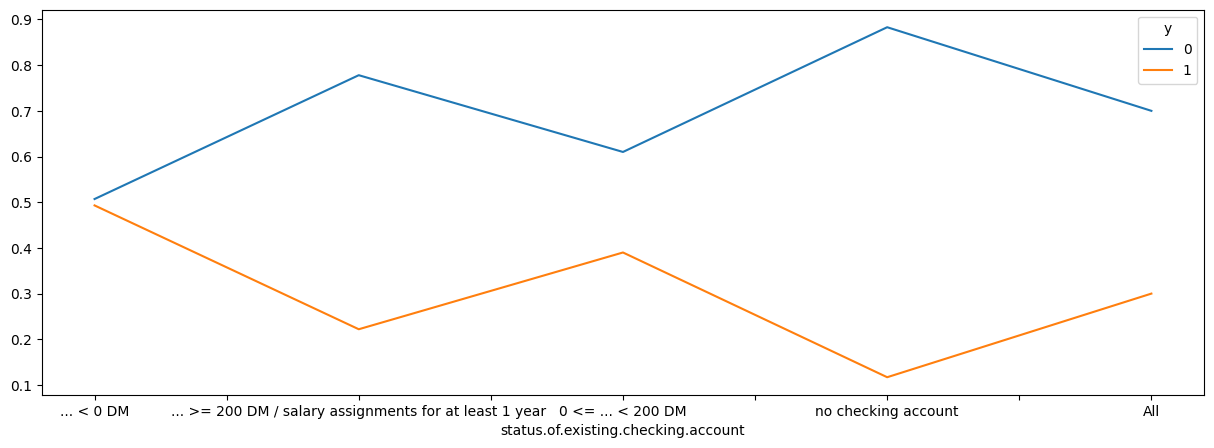

In [15]:
pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))


Como hay un 30% de malos en el dataset. Miro a ver si el % de la variable supera el 30%     


Puedo observar que en los grupos de clientes que tienen saldo negativo o <200 ➡️ hay muchos malos clientes

---
### Personal status and sex

In [16]:
ctabla=pd.crosstab(dt['personal.status.and.sex'],dt['y'],margins=True).round(3)
ctabla

y,0,1,All
personal.status.and.sex,,,
female : divorced/separated/married,221,89,310
male : divorced/separated,38,12,50
male : married/widowed,61,31,92
male : single,380,168,548
All,700,300,1000


Esta tabla no aporta información, sólo sirve para calcular el chi cuadrado

In [17]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)

0.9861956857599425


    Esta variable no es significativa

---
### Housing

Vivienda en alquiler, propiedad o cedida 

In [18]:
ctabla=pd.crosstab(dt['housing'],dt['y'],margins=True).round(3)
ctabla

y,0,1,All
housing,,,
for free,64,44,108
own,527,186,713
rent,109,70,179
All,700,300,1000


In [19]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)

0.005751713700914466


    Es significativa 

 ....  Habría que seguir haciendo esto con todas las variables categóricas para analizar asociación

----
----
# Analisis de Asociación
## Variables Continuas

Detecto aquí a ver si hay alguna variable que está mal 

In [20]:
dt.describe()

,Unnamed: 0,duration.in.month,credit.amount,installment.rate.in.percentage.of.disposable.income,present.residence.since,age.in.years,number.of.existing.credits.at.this.bank,number.of.people.being.liable.to.provide.maintenance.for,y
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.300000
std,288.819436,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,0.000000,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,249.750000,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,499.500000,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,0.000000
75%,749.250000,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,999.000000,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


### Credit.amount 

#### Representación gráfica 

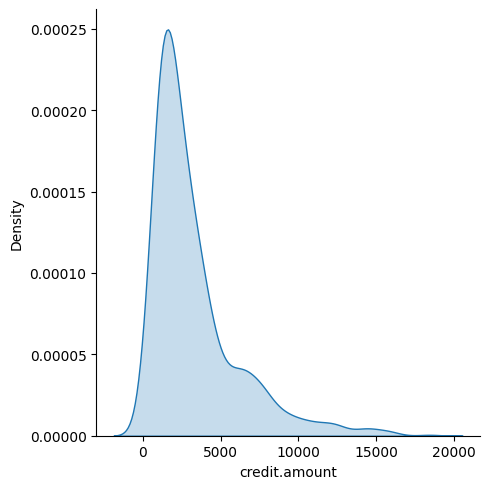

In [21]:
sns.displot(x=(dt['credit.amount']), kind="kde", fill=True)
plt.show()

#### Transformación logarítmica

Histograma asimétrica ➡️ **Realizo una transformación logarítmica**

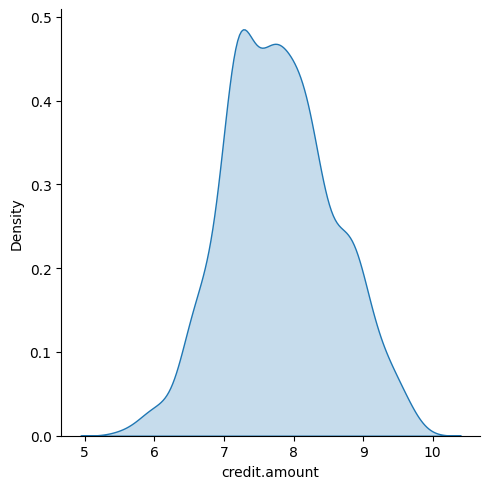

In [22]:
sns.displot(x=np.log(dt['credit.amount']), kind="kde", fill=True)
plt.show()

He conseguido que sea más simétrica. Cambio la columna original por los valores del logaritmo

In [23]:
dt['credit.amount']=np.log(dt['credit.amount'])

 ---
#### Puntos de corte para tramificar
No normalizo para poder identificar los puntos de corte, los puntos donde hay comportamientos diferentes. Tengo que tramificar variables para identificar buenos

    - Hasta el 7: Malos = Buenos
    - De 7 a 8,4: Buenos > Malos
    - Desde 8,4: Malos > Buenos 

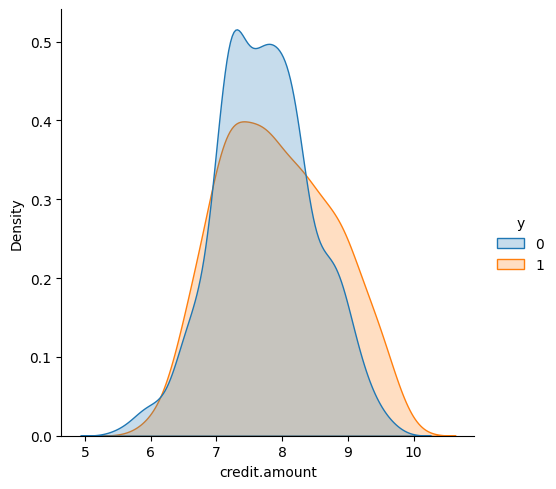

In [24]:
sns.displot(x=(dt['credit.amount']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

---
#### Estadístico F
Miro la asociación con un test de **diferencia de medias**

In [25]:
fvalue, pvalue = f_oneway(dt.loc[dt["y"]==0,['credit.amount']], dt.loc[dt["y"]==1,['credit.amount']])
print(fvalue, pvalue)


[12.12709264] [0.00051849]


    El P - Valor indica que es significativo

---
### duration.in.month

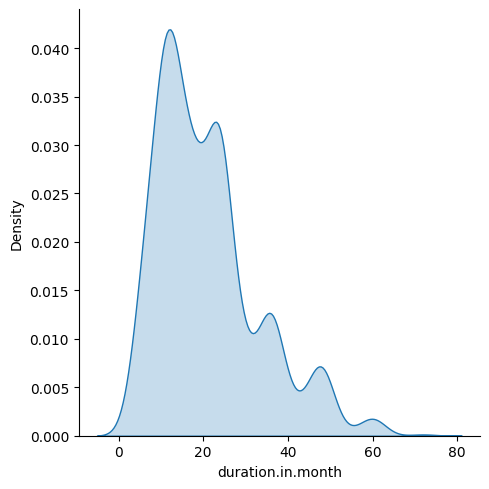

In [26]:
sns.displot(x=(dt['duration.in.month']), kind="kde", fill=True)
plt.show()

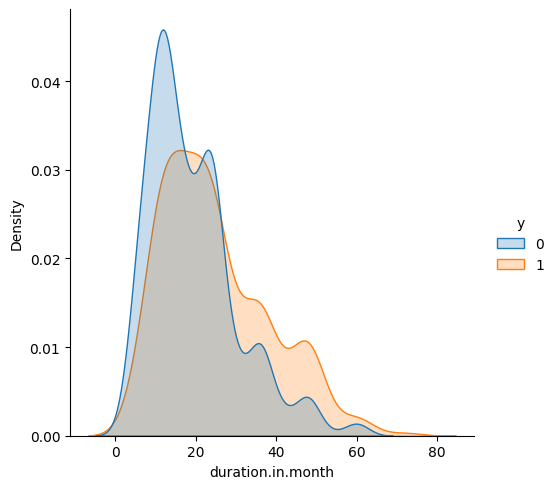

In [27]:
sns.displot(x=(dt['duration.in.month']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

    A partir de los 25 meses, hay más clientes malos que buenos 

In [28]:
fvalue, pvalue = f_oneway(dt.loc[dt["y"]==0,['duration.in.month']], dt.loc[dt["y"]==1,['duration.in.month']])
print(fvalue, pvalue)

[48.33379013] [6.48804988e-12]


    La variable es significativa

Calcula todos los posibles asociaciones entre todas las variables entre todas las variables. Está normalizado, esto no sirve para nada 

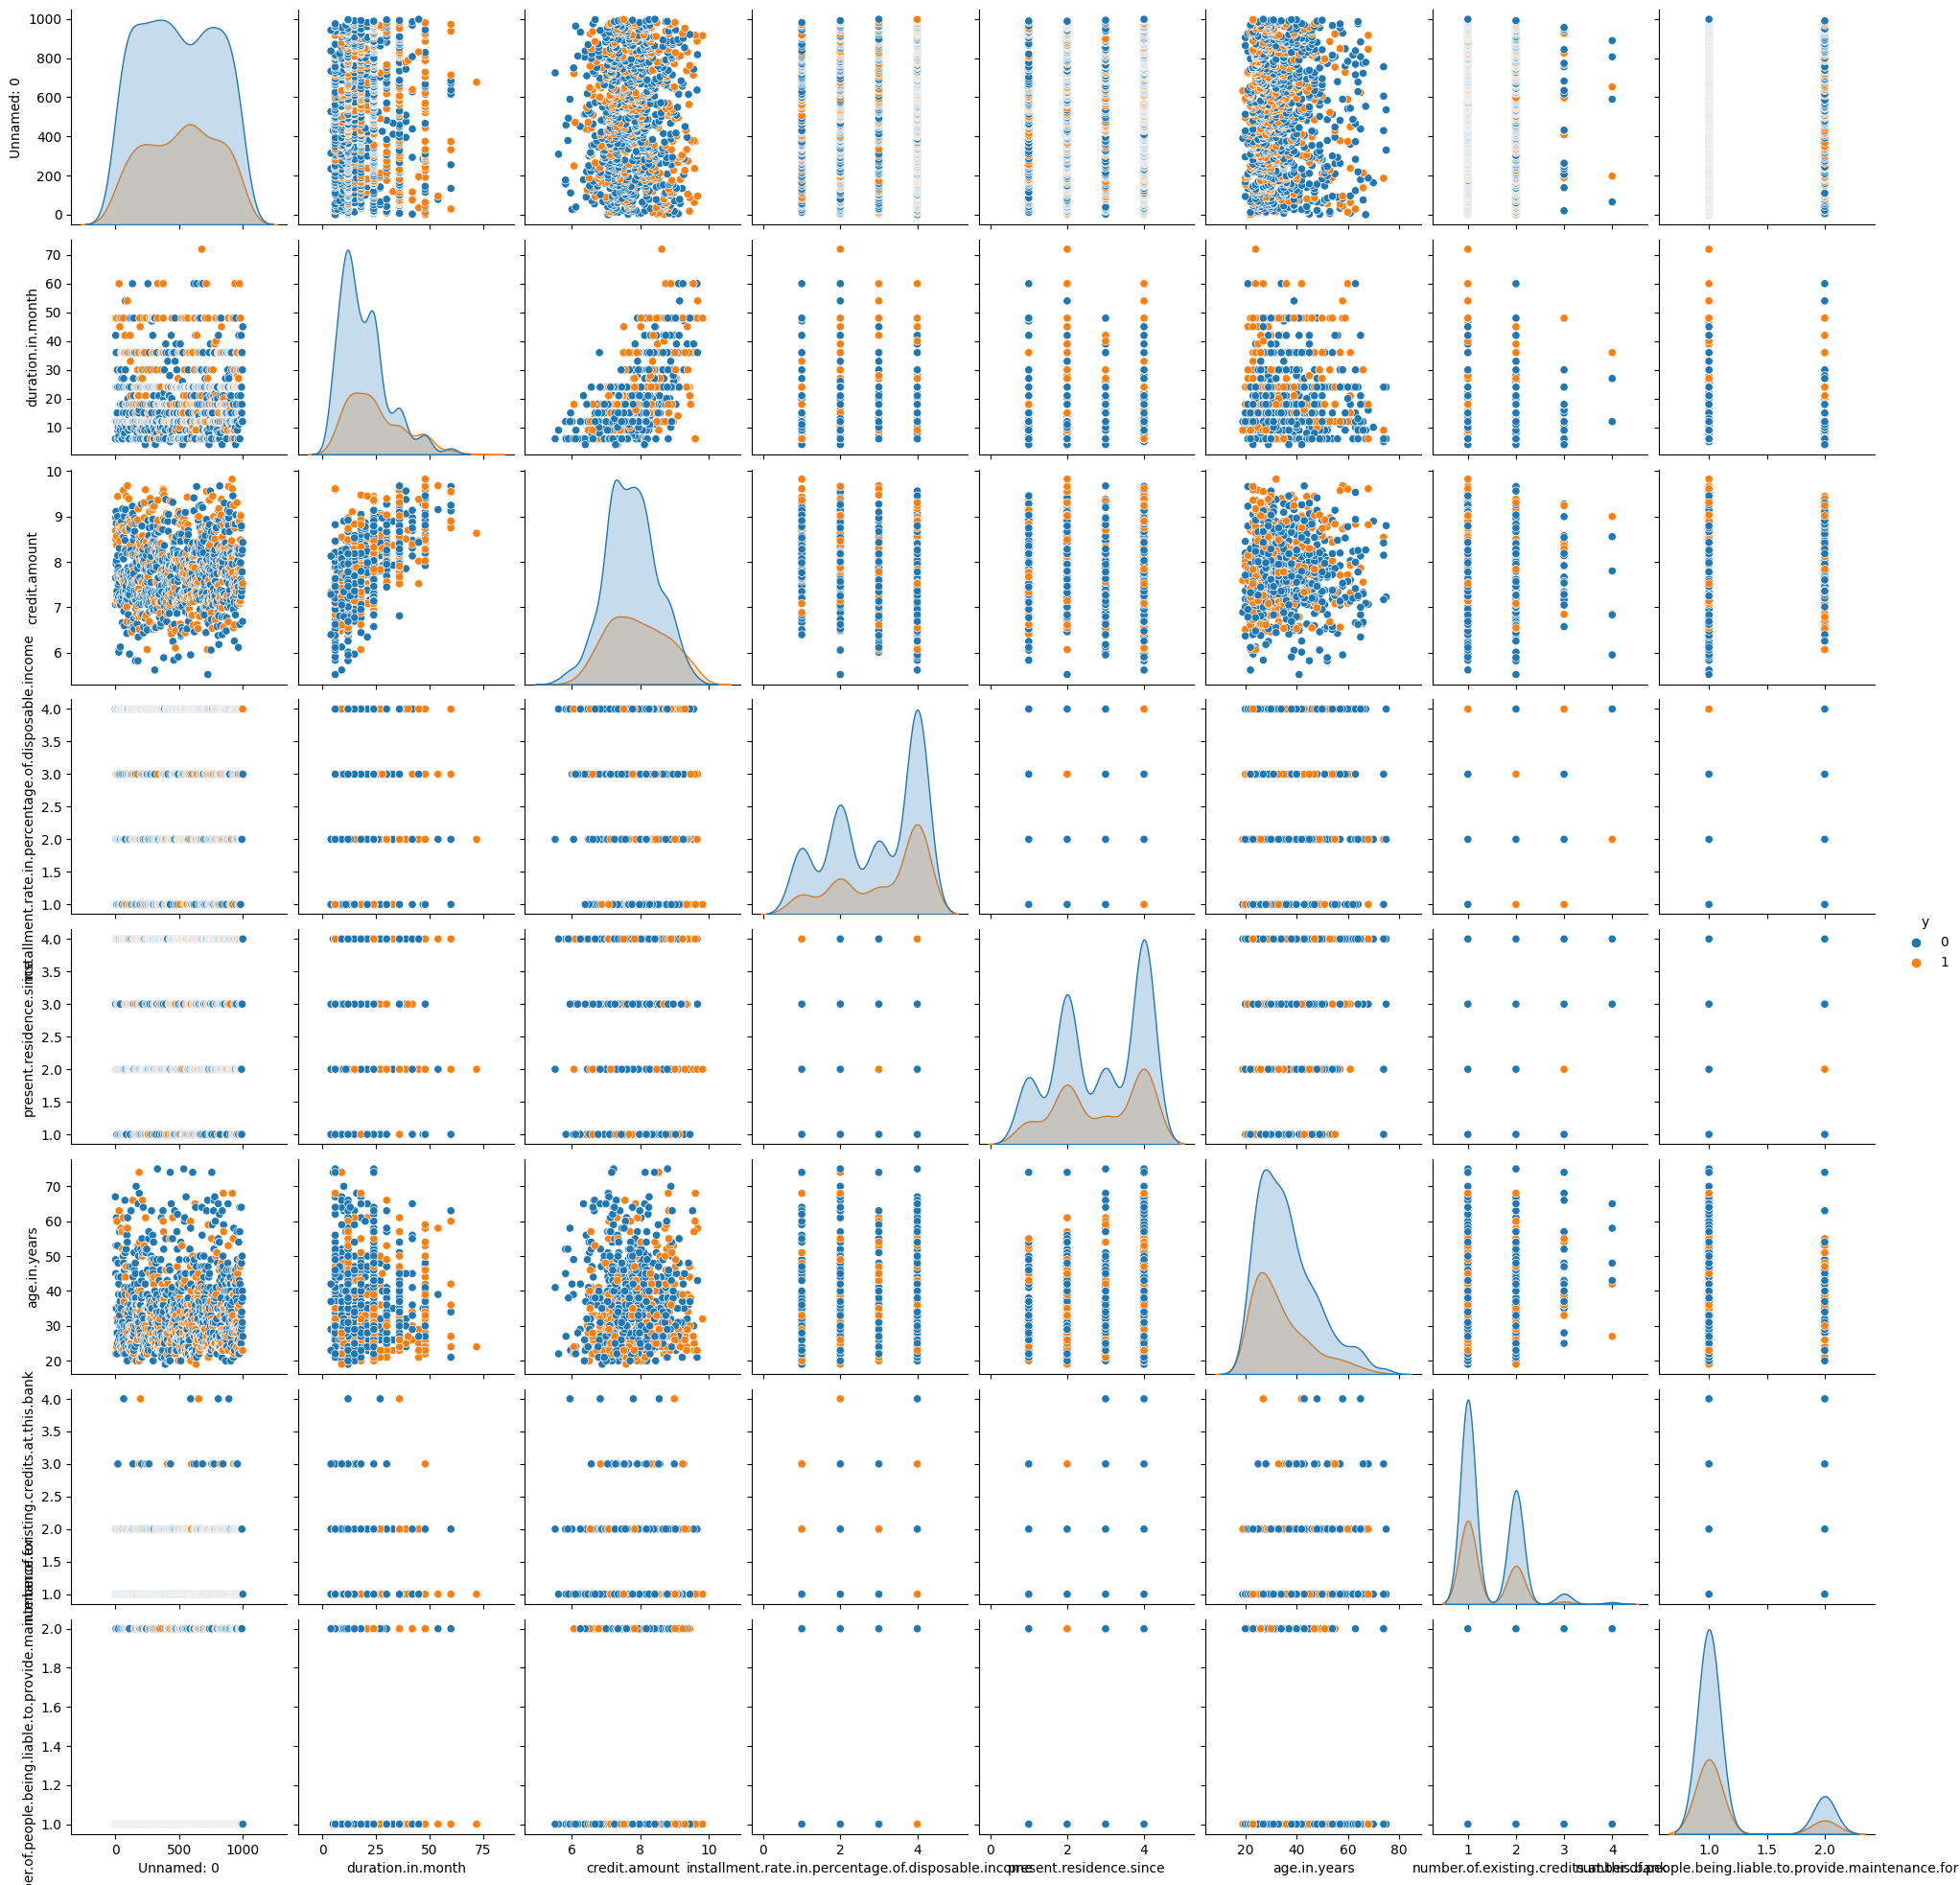

In [29]:
sns.pairplot(dt, hue="y")

---
---
# Análisis concentración 

Para seleccionar las variables más **importantes** para meter en el modelo

### Dividimos la muestra en entrenamiento y test
Con estratificación de la variable y, para que en cada partición haya un 30%  de malos

In [30]:
dt_train, dt_test = train_test_split(dt,stratify=dt["y"], test_size=.25, random_state=1234)

In [31]:
dt_train["y"].shape

(750,)

Porcentaje de 1 de la muestra

In [32]:
dt_train["y"].mean()

0.3

In [33]:
dt_test["y"].shape

(250,)

In [34]:
dt_test["y"].mean()

0.3

---
---
# Tramificación Óptima

## Tramificación de la Variable: "credit.amount"

#### Defino la variable X e Y

In [35]:
variable="credit.amount"
X=dt_train[variable].values
Y=dt_train['y'].values

----
#### OptimalBinning
OptimalBinning Realiza un árbol de decisión para calcular cuáles son los puntos óptimos para tramificar, maximizando el WOE y el VI

In [36]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

# Si se quisiese fijar los intervalos manualmente (porque no gusten los que obtine el agoritmo, entonces habría que usar:
#                     user_splits=
#                     user_splits_fixed=
# HAy veces que los datos tienen dátos missing y códigos especiales en este caso para obtener una categoría con esos datos missing y datos especiales hay que establecerlos
#                     special_codes = [-9, -8, -7]

# Una vez definido podemos pasar a estimarlo
optb.fit(X, Y)
optb.splits

array([6.86641216, 7.22475314, 7.31455255, 7.4804244 , 8.30634689,
       8.96692848])

Como me ha dado 6 puntos, tengo 7 tramos 

Nota: Por defecto se utiliza un arbol de clasificación para hacer una tramificación inicial, y después se aplica un proceso de optimización de agrupación de categorías para maximizar el Valor de Información 

Una vez realizado el proceso de tramificación y agrupación óptima de categorías, obtenemos la tabla de agrupación 

In [37]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6.87)",81,0.108000,53,28,0.345679,-0.20921,0.004915,0.000613
1,"[6.87, 7.22)",105,0.140000,71,34,0.323810,-0.110979,0.001762,0.000220
2,"[7.22, 7.31)",40,0.053333,32,8,0.200000,0.538997,0.013689,0.001691
3,"[7.31, 7.48)",47,0.062667,43,4,0.085106,1.527608,0.097961,0.011178
4,"[7.48, 8.31)",293,0.390667,222,71,0.242321,0.2927,0.031407,0.003912
5,"[8.31, 8.97)",129,0.172000,81,48,0.372093,-0.32405,0.019134,0.002381
6,"[8.97, inf)",55,0.073333,23,32,0.581818,-1.17754,0.115885,0.013703
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.284752,0.033698


El porcentaje de eventos es el porcentaje de 1. Me aparece por defecto 2 tramos adicionales (outliers y missings, pero en este caso no hay .

Podemos realizar un test de independencia entre la nueva variable categórica y la variable objetivo "Event" 

Cabe mencionar que el WOE en esta tabla parece estar definido al revés que lo hemos hecho en clase, por lo que el signo es justo el contrario al que cabría esperar según lo que hemos visto en clase. En particular por defecto `optbinning` define el WOE de una categoría $i$ como
$$ WOE_i =  ln \left ( {Non-event_i \over Non-event_{total}} \over {Event_i \over Event_{total}}    \right ) $$

En este sentido los niveles con mayor tasa de impagados tendrán un WOE menos, y a medida que se reduzca la tasa de impagados (mejor calidad crediticia) irá aumentando el WOE

----
####  IV y Gini

Podemos extraer el IV y el índice de Gini a partir de la tabla

In [38]:
print("IV= ", binning_table.iv.round(3))
print("Gini= ", binning_table.gini.round(3))

IV=  0.285
Gini=  0.265


----
#### Tramificación

También podemos realizar una representación gráfica de la Tabla de tramificación



**Por WOE**

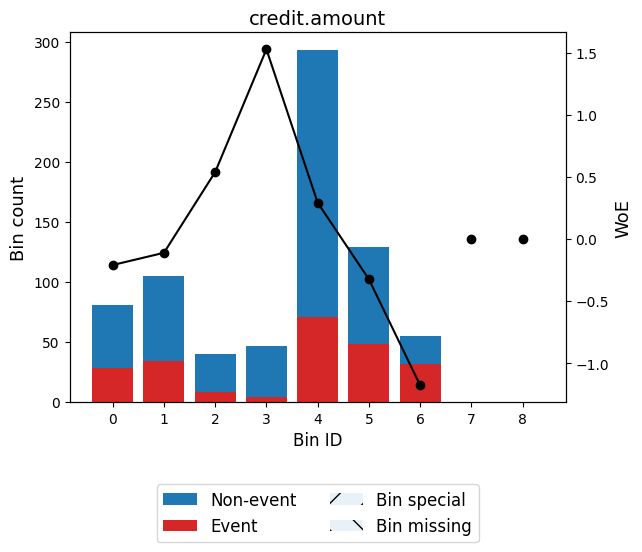

In [39]:
binning_table.plot(metric="woe")

**Por tasa de evento**

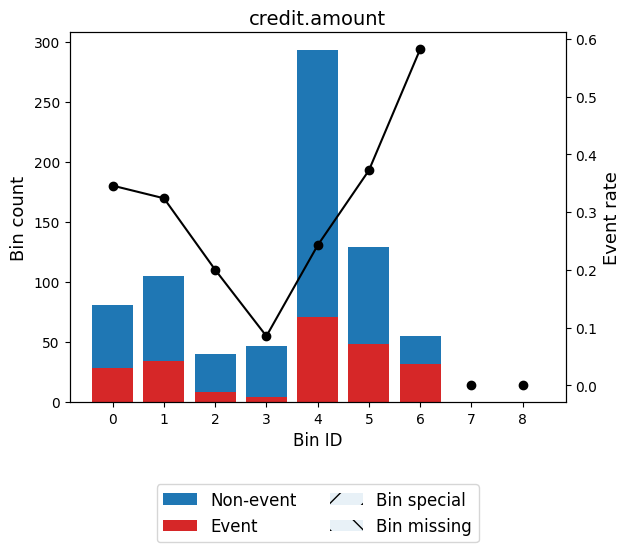

In [40]:
binning_table.plot(metric="event_rate")

La relación entre credit.amount y la tasa de evento (impago) es no lineal.

Cojo la tasa de evento (% de 1) ➡️ 30%. Trazo una línea:

 * Tramo 2,3 y 4 tienen un % < 30
 * Tramo 5,6 tienen un % bastante > a 30%, por lo que si alguien cae en este tramo es muy probable de que sea malo

----
####  Transformación WOE

#### ➡ Data

Ahora podemos aplicar esta tramificación óptima a la variable original y obtener la variable transformada WOE (que será una variable continua que utilizaremos en el modelode regresión)

In [41]:
# Transformación WOE
x_woe = optb.transform(X, metric="woe")
pd.Series(x_woe).value_counts().sort_index()

-1.177540     55
-0.324050    129
-0.209210     81
-0.110979    105
 0.292700    293
 0.538997     40
 1.527608     47
dtype: int64

Creo una nueva variable 'x_woe', a cada una de las categorías le asignamos su valor WOE, hay 7 valores diferentes

Fíjate que ahora hemos conseguido "linealizar" la relación entre la variable trasnformada Woe y la propensión al impago 

In [42]:
pd.crosstab(x_woe,Y,normalize=0).round(3)

col_0,0,1
row_0,,
-1.177540,0.418,0.582
-0.324050,0.628,0.372
-0.209210,0.654,0.346
-0.110979,0.676,0.324
0.292700,0.758,0.242
0.538997,0.800,0.200
1.527608,0.915,0.085


Text(0, 0.5, 'porcentaje de impago')

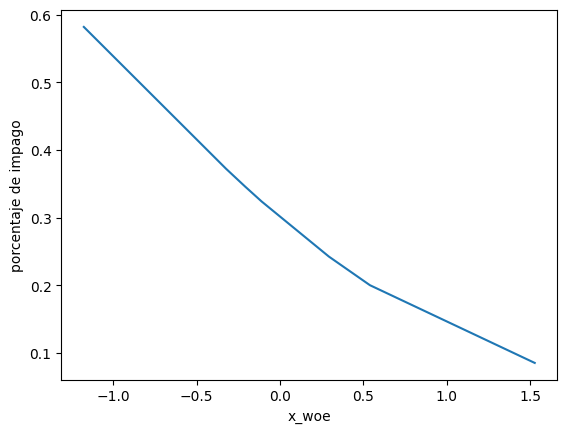

In [43]:
fig, ax = plt.subplots()
ax.plot(pd.crosstab(x_woe,Y,normalize=0).iloc[:,1])
ax.set_xlabel("x_woe")
ax.set_ylabel("porcentaje de impago")

#### ➡ Test

Nótese que para hacer la validación deberíamos hacer exactamente la misma transformación WOE, con la misma tramificación, al conjunto test. Para ello debemos aplicar la transformación optima calculada con el conjunto de entrenamiento, pero sobre la muestra de validación 

In [44]:
# Transformación WOE en el conjunto test
x_test_woe = optb.transform(dt_test[variable].values, metric="woe")
pd.Series(x_test_woe).value_counts().sort_index()

-1.177540    20
-0.324050    38
-0.209210    28
-0.110979    39
 0.292700    96
 0.538997    14
 1.527608    15
dtype: int64

Nótese que **no** estamos calculando una nueva tramificación para el conjunto de test, sino aplicando la tramificación obtenida con el conjunto de entrenamiento.    
En realidad si hiciéramos una tramificación óptima con el conjunto de test no tendría porqué salir igual que la estimada para el conunto de entrenamiento, como se puede comprobar a continuación

In [45]:
variable="credit.amount"
X_test=dt_test[variable].values
Y_test=dt_test['y'].values
optb_test = OptimalBinning(name=variable, dtype="numerical")
optb_test.fit(X_test, Y_test)
print(optb_test.splits)
binning_table_test = optb_test.binning_table
binning_table_test.build()

[6.59098554 7.06933808 7.31653738 8.8512311  9.1008029 ]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6.59)",15,0.060,12,3,0.200000,0.538997,0.015400,0.001902
1,"[6.59, 7.07)",29,0.116,23,6,0.206897,0.496437,0.025531,0.003159
2,"[7.07, 7.32)",37,0.148,27,10,0.270270,0.145954,0.003058,0.000382
3,"[7.32, 8.85)",140,0.560,98,42,0.300000,0.0,0.000000,0.000000
4,"[8.85, 9.10)",15,0.060,9,6,0.400000,-0.441833,0.012624,0.001565
5,"[9.10, inf)",14,0.056,6,8,0.571429,-1.13498,0.082151,0.009751
6,Special,0,0.000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,250,1.000,175,75,0.300000,,0.138764,0.016759


Nótese que con el conjunto de test se han obtenido sólo 6 tramos y con diferentes puntos de corte ( y diferentes WOE), por eso es necesario no hacer una nueva tramificación al conjunto de test sino aplicar la tramificación obtenida usando en el conjunto de entrenamiento

---
## Tramificación de la duración en meses

In [46]:
variable="duration.in.month"
X=dt_train[variable].values
Y=dt_train['y'].values

optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

optb.fit(X, Y)
optb.splits

array([ 7.5, 11.5, 15.5, 34.5, 43.5])

In [47]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 7.50)",65,0.086667,59,6,0.092308,1.43848,0.123298,0.014207
1,"[7.50, 11.50)",70,0.093333,56,14,0.200000,0.538997,0.023955,0.002959
2,"[11.50, 15.50)",192,0.256000,145,47,0.244792,0.279288,0.018797,0.002342
3,"[15.50, 34.50)",293,0.390667,195,98,0.334471,-0.159266,0.010213,0.001275
4,"[34.50, 43.50)",83,0.110667,49,34,0.409639,-0.481838,0.027840,0.003447
5,"[43.50, inf)",47,0.062667,21,26,0.553191,-1.060872,0.080155,0.009574
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.284258,0.033804


In [48]:
print("IV= ", binning_table.iv.round(3))
print("Gini= ", binning_table.gini.round(3))


IV=  0.284
Gini=  0.269


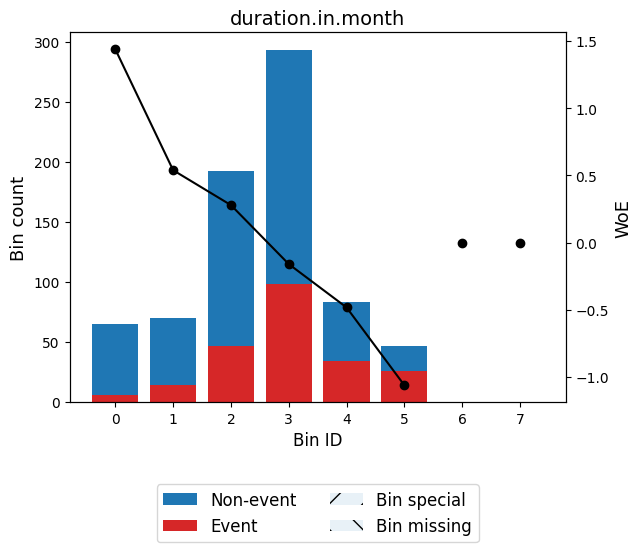

In [49]:
binning_table.plot(metric="woe")

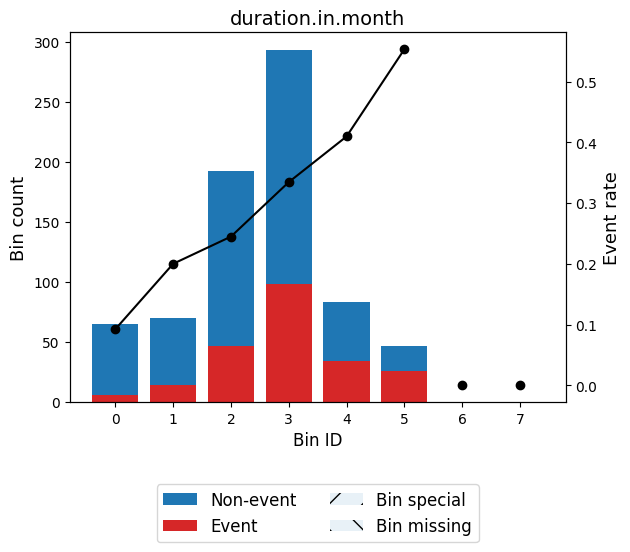

In [50]:
binning_table.plot(metric="event_rate")

In [51]:
# Transformación WOE
x_woe = optb.transform(X, metric="woe")
pd.Series(x_woe).value_counts().sort_index

<bound method Series.sort_index of -0.159266    293
 0.279288    192
-0.481838     83
 0.538997     70
 1.438480     65
-1.060872     47
dtype: int64>

---
---
# Agrupción de niveles en variables Vbles Categóricas

En realidad, cuando tenemos variables categóricas, no es necesario tramificar, pero sí hacer una agrupación de los diferentes niveles de forma que se maximice el *valor de información*

## Agrupación de la variable  *purpose*

In [52]:
variable_cat = "purpose"
X_cat = dt_train[variable_cat].values
Y_cat = dt_train['y'].values

dt_train[variable_cat].value_counts()

radio/television       221
car (new)              170
furniture/equipment    134
car (used)              82
business                70
education               36
repairs                 13
others                  10
domestic appliances      9
retraining               5
Name: purpose, dtype: int64

In [53]:
optb = OptimalBinning(name=variable_cat, dtype="categorical", solver="mip",
                      cat_cutoff=0.1)

optb.fit(X_cat, Y_cat)
optb.splits

[array(['car (used)'], dtype=object),
 array(['radio/television'], dtype=object),
 array(['furniture/equipment'], dtype=object),
 array(['car (new)'], dtype=object),
 array(['business', 'education', 'repairs', 'others',
        'domestic appliances', 'retraining'], dtype=object)]

In [54]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[car (used)],82,0.109333,67,15,0.182927,0.649345,0.039579,0.004862
1,[radio/television],221,0.294667,172,49,0.221719,0.408376,0.044857,0.005568
2,[furniture/equipment],134,0.178667,92,42,0.313433,-0.063179,0.000722,0.000090
3,[car (new)],170,0.226667,109,61,0.358824,-0.266824,0.016941,0.002111
4,"[business, education, repairs, others, domesti...",143,0.190667,85,58,0.405594,-0.46509,0.044590,0.005524
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.146688,0.018156


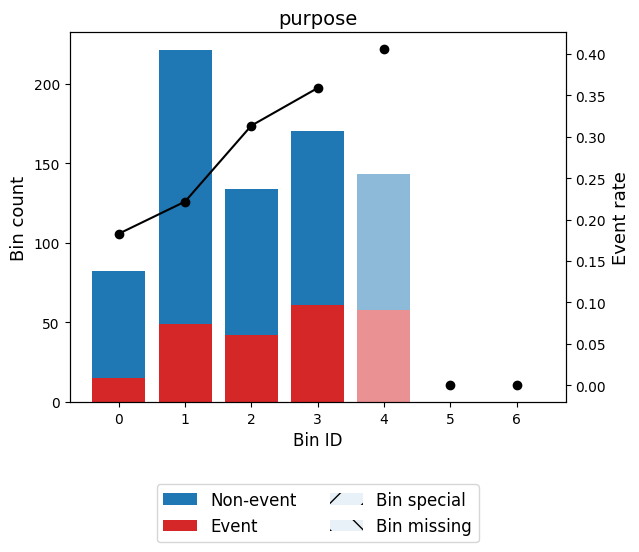

In [55]:
binning_table.plot(metric="event_rate")

In [56]:
x_woe = optb.transform(X_cat, metric="woe")
pd.Series(x_woe).value_counts()


 0.408376    221
-0.266824    170
-0.465090    143
-0.063179    134
 0.649345     82
dtype: int64

__________________________________________________________________________________________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________________________________________________________________________________________

# Proceso de tramificación, agrupación y trasformación WOE Completo

Para no ir variable a variable se puede hacer todo el proceso completo

Proceso Entero



In [57]:
# 1) Definimos la lista de nombres señalando cualse de ellas son las categóricas
Y = dt_train['y'].values
X = dt_train.drop(columns=['Unnamed: 0','y']) #todas menos la primera que es el ID y la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

In [58]:
# 2) Definimos el criterio de selección, valor de la información es > 0,2
selection_criteria = {
    "iv": {"min": 0.02, "max": 1}
}

In [59]:
# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria)


In [60]:
# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

Lo de foreign.worker es porque habría que eliminar esta variable, sólo el 3% de personas lo son

In [61]:
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
19,foreign.worker,categorical,OPTIMAL,False,1,0.0,0.0,0,0.0
17,number.of.people.being.liable.to.provide.maint...,numerical,OPTIMAL,False,2,0.000027,0.000003,0.001905,0.000002
18,telephone,categorical,OPTIMAL,False,2,0.006555,0.000819,0.039365,0.011947
16,job,categorical,OPTIMAL,False,3,0.006597,0.000824,0.035564,0.002399
10,present.residence.since,numerical,OPTIMAL,False,2,0.006759,0.000843,0.026667,0.005661
15,number.of.existing.credits.at.this.bank,numerical,OPTIMAL,False,2,0.007712,0.000964,0.04254,0.014758
8,personal.status.and.sex,categorical,OPTIMAL,False,3,0.011838,0.001478,0.055467,0.009888
9,other.debtors.or.guarantors,categorical,OPTIMAL,True,2,0.025861,0.003165,0.033651,0.013879
13,other.installment.plans,categorical,OPTIMAL,True,2,0.042562,0.00529,0.08254,0.070816
7,installment.rate.in.percentage.of.disposable.i...,numerical,OPTIMAL,True,3,0.082514,0.010266,0.148301,0.143666


In [62]:
# Ahora podemos ir sacando las tablas para cada variable
dt_train_binned.get_binned_variable("credit.amount").binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6.87)",81,0.108000,53,28,0.345679,-0.20921,0.004915,0.000613
1,"[6.87, 7.22)",105,0.140000,71,34,0.323810,-0.110979,0.001762,0.000220
2,"[7.22, 7.31)",40,0.053333,32,8,0.200000,0.538997,0.013689,0.001691
3,"[7.31, 7.48)",47,0.062667,43,4,0.085106,1.527608,0.097961,0.011178
4,"[7.48, 8.31)",293,0.390667,222,71,0.242321,0.2927,0.031407,0.003912
5,"[8.31, 8.97)",129,0.172000,81,48,0.372093,-0.32405,0.019134,0.002381
6,"[8.97, inf)",55,0.073333,23,32,0.581818,-1.17754,0.115885,0.013703
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.284752,0.033698


In [63]:
dt_train_binned.get_binned_variable("purpose").binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[retraining, car (used)]",87,0.116000,72,15,0.172414,0.721318,0.050836,0.006220
1,[radio/television],221,0.294667,172,49,0.221719,0.408376,0.044857,0.005568
2,"[furniture/equipment, domestic appliances]",143,0.190667,98,45,0.314685,-0.068993,0.000920,0.000115
3,[business],70,0.093333,45,25,0.357143,-0.259511,0.006591,0.000822
4,[car (new)],170,0.226667,109,61,0.358824,-0.266824,0.016941,0.002111
5,"[repairs, others, education]",59,0.078667,29,30,0.508475,-0.881199,0.068817,0.008334
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,750,1.000000,525,225,0.300000,,0.188962,0.023171


In [64]:
dt_train_binned.information()

optbinning (Version 0.17.3)
Copyright (c) 2019-2022 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records                    750
    Number of variables                   20
    Target type                       binary

    Number of numerical                    7
    Number of categorical                 13
    Number of selected                    13

  Time                                0.8620 sec



In [65]:
# las variables seleccionadas se pueden obtener con 'get_support'"Tarea Estudiantes_TarjetaPuntuacion"
dt_train_binned.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True, False, False, False,
       False, False])

In [66]:
# Podemos transformar las variables WOE
dt_train_woe=dt_train_binned.transform(X, metric="woe")

# Existe la posibilidad de obtener directamente las transformada si en lugar de usar fit, hubiésemos usado fit_transform 
# dt_train_binned = binning_process.fit_transform(X, Y)
# dt_train_binned.info()
# el resultado sería un data.frame con las X seleccionadas trasnsformadas WOE

In [67]:
dt_train_woe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 13 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   status.of.existing.checking.account                  750 non-null    float64
 1   duration.in.month                                    750 non-null    float64
 2   credit.history                                       750 non-null    float64
 3   purpose                                              750 non-null    float64
 4   credit.amount                                        750 non-null    float64
 5   savings.account.and.bonds                            750 non-null    float64
 6   present.employment.since                             750 non-null    float64
 7   installment.rate.in.percentage.of.disposable.income  750 non-null    float64
 8   other.debtors.or.guarantors                          750 non-null    f

In [68]:
dt_train_woe

,status.of.existing.checking.account,duration.in.month,credit.history,purpose,credit.amount,savings.account.and.bonds,present.employment.since,installment.rate.in.percentage.of.disposable.income,other.debtors.or.guarantors,property,age.in.years,other.installment.plans,housing
0,-0.336472,-0.481838,0.640779,0.408376,-0.324050,-0.213184,0.386234,0.237709,0.733153,0.380307,-0.513292,0.103678,0.200394
1,-0.336472,-0.159266,-0.107989,0.721318,-0.324050,0.664160,-0.405465,0.470943,-0.035349,0.380307,0.158722,0.103678,0.200394
2,1.117733,-0.159266,0.640779,0.408376,0.292700,-0.213184,-0.027857,-0.270514,-0.035349,-0.076961,-0.513292,0.103678,0.200394
3,1.117733,0.279288,0.640779,0.408376,0.538997,-0.213184,-0.027857,-0.270514,-0.035349,-0.574431,0.781943,0.103678,-0.552498
4,0.305382,0.279288,-0.107989,0.408376,0.292700,0.664160,0.237328,0.237709,-0.035349,-0.076961,0.474458,0.103678,0.200394
...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,-0.336472,-0.159266,-0.107989,0.408376,-0.110979,-0.213184,0.237328,-0.270514,0.733153,0.380307,-0.065203,0.103678,0.200394
746,1.117733,0.279288,-0.107989,-0.266824,0.292700,0.664160,0.237328,-0.270514,-0.035349,-0.574431,0.158722,0.103678,-0.552498
747,-0.336472,-0.481838,0.058411,-0.266824,0.292700,-0.135802,0.237328,-0.270514,-0.035349,-0.574431,-0.065203,0.103678,-0.552498
748,-0.336472,-1.060872,-1.200119,-0.881199,-1.177540,-0.135802,0.237328,0.237709,-0.035349,-0.574431,0.158722,-0.411980,-0.552498


In [69]:
# Ahora aplicaríamos la misma transformación pero al conjunto de test (si hubiera que puntuar a nuevos clientes haríamos lo mismo)

Y_test = dt_test['y'].values
X_test = dt_test.drop(columns=['Unnamed: 0','y']) #todas menos la primera que es el ID y la variable y

dt_test_woe=dt_train_binned.transform(X_test, metric="woe")
dt_test_woe.info()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 13 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   status.of.existing.checking.account                  250 non-null    float64
 1   duration.in.month                                    250 non-null    float64
 2   credit.history                                       250 non-null    float64
 3   purpose                                              250 non-null    float64
 4   credit.amount                                        250 non-null    float64
 5   savings.account.and.bonds                            250 non-null    float64
 6   present.employment.since                             250 non-null    float64
 7   installment.rate.in.percentage.of.disposable.income  250 non-null    float64
 8   other.debtors.or.guarantors                          250 non-null    f

In [70]:
dt_test_woe

,status.of.existing.checking.account,duration.in.month,credit.history,purpose,credit.amount,savings.account.and.bonds,present.employment.since,installment.rate.in.percentage.of.disposable.income,other.debtors.or.guarantors,property,age.in.years,other.installment.plans,housing
0,-0.336472,-1.060872,-0.107989,-0.068993,-1.177540,-0.213184,-0.461635,0.470943,-0.035349,-0.076961,-0.070769,0.103678,0.200394
1,-0.877451,0.279288,-0.107989,-0.266824,-1.177540,-0.213184,0.237328,0.470943,-0.035349,0.138836,0.158722,0.103678,0.200394
2,1.117733,-0.159266,0.640779,0.408376,-0.324050,-0.213184,0.386234,-0.270514,-0.035349,-0.076961,-0.070769,0.103678,-0.408385
3,1.117733,0.279288,-0.107989,-0.259511,-0.110979,-0.213184,-0.027857,0.237709,-0.035349,0.380307,-0.070769,0.103678,0.200394
4,0.305382,0.538997,-0.107989,0.408376,-0.110979,-0.135802,0.237328,0.237709,-0.035349,0.380307,0.158722,0.103678,0.200394
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1.117733,0.279288,-0.107989,-0.266824,0.292700,0.664160,-0.027857,0.237709,-0.035349,-0.574431,-0.070769,0.103678,0.200394
246,-0.336472,0.279288,-0.107989,0.408376,-0.209210,-0.213184,0.237328,-0.270514,-0.035349,-0.076961,0.474458,0.103678,0.200394
247,-0.877451,-0.159266,0.640779,-0.266824,-0.110979,-0.213184,0.237328,-0.270514,-0.035349,-0.076961,0.158722,0.103678,0.200394
248,0.305382,1.438480,0.640779,-0.266824,-0.110979,-0.213184,0.237328,0.470943,-0.035349,0.380307,0.158722,0.103678,0.200394


# Estimación del Modelo

Ahora podemos calcular la tarjeta de puntuación. En los apuntes de clase definimos tanto los WOE, como los Odd ratio como la probabilidad de `evento` respecto al `no-evento` (malos clientes o impago=1 respecto a los buenos clientes o impago=0):

$$ odd = {{P}\over {(1-P)}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$
 
 Y la fórmula para obtener la puntuación o los score debe ser una relación negativa con los odd ratio: cuanto mayor la probabilidad de impago (en relación a la de no impago), menor puntuación ha de tener: 

 $$ score {= offset - Factor}~·~{ln(odds)}$$

 para obtener los valores concretos de esta recta que transforma probabilidades a puntos (para conocer el valor de $offset$ y de $Factor$), hay que decidir de manera arbitraria una pendiente y un punto de la anterior recta. Para la pendiente suele establecerse cada cuántos puntos de score (**pdo_0**) que dobla el odd ratio: $ score - pdo_0 = {offset -Factor}~ ·{ln(2*odds)}$. Mientras que para establecer un punto de la recta se establece una puntuación o score arbitraria que se considere que debería tener un cliente con una calidad credicitica de *sobresaliente* (**scorecard_points**), y también el odd ratio que debería tener ese cliente de *sobresaliente* (**odds_0**). Así habría que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40
* **scorecard_points** =600 
* **odds_0** =1/50

La librería `optBinning` [librería OptBinning](http://gnpalencia.org/optbinning/), en realidad utiliza el módulo de `credit scoring` de `SAS-miner` como inspiración, y por eso define al revés tanto los WOE como los odd ratio, es decir `no-evento` en relación a `evento` (clientes buenos respecto a los malos, o no-impago respecto a impago, impago=0 respecto a impago=1). 
$$ odd^B = {{(1-P)}\over {P}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$

Esto implica que la ecuación que transforma las probabilidades de impago en scores utilizando esta *odds<sup>B</sup>* debe tener pendiente positiva (cuanto mejor *odd<sup>B</sup>* mejor calidad crediticia tiene el cliente)

 $$ score= {offset + Factor} ~·~ {ln(odds^B)}$$
 
 Nótese que ahora habrá que establecer de nuevo los puntos de score que doblan el odd ratio (**pdo_0**), y también la puntuación o score considerada como de sobresaliente(**scorecard_points**) y el odd ratio que debería tener ese cliente de *sobresaliente* **odds_0 <sup>*B*</sup>**, con **odds_0 <sup>*B*</sup>** **= 1/odds_0**.

 Así para estimar la puntuación crediticia con `optBinning` hay que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40
* **scorecard_points** =600 
* **odds_0 <sup>*B*</sup>** = 50  (equivalente a **odds_0** =1/50 )




In [71]:
# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

In [72]:
tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

In [73]:
tarjeta.fit(X, Y, show_digits=4)

Scorecard(binning_process=BinningProcess(categorical_variables=['status.of.existing.checking.account',
                                                                'credit.history',
                                                                'purpose',
                                                                'savings.account.and.bonds',
                                                                'present.employment.since',
                                                                'personal.status.and.sex',
                                                                'other.debtors.or.guarantors',
                                                                'property',
                                                                'other.installment.plans',
                                                                'housing',
                                                                'job',
                                                                'telephone',
                                                                'foreign.worker'],
                                         selection_criteria={'iv': {'...
                                                         'other.debtors.or.guarantors',
                                                         'present.residence.since',
                                                         'property',
                                                         'age.in.years',
                                                         'other.installment.plans',
                                                         'housing',
                                                         'number.of.existing.credits.at.this.bank',
                                                         'job',
                                                         'number.of.people.being.liable.to.provide.maintenance.for',
                                                         'telephone',
                                                         'foreign.worker']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [74]:
tarjeta.information(print_level=2)

optbinning (Version 0.17.3)
Copyright (c) 2019-2022 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                  pdo_odds   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                    750
    Number of variables                   20
    Target type                       binary

    Number of numerical                    7
    Number of categorical                 13
    Number of selected                    13

  Timing
    Total time                          0.96 sec
    Binning process                     0.91 sec   ( 94.61%)
    Estimator                           0.01 sec   (  0.95%

In [75]:
tarjeta.table(style="detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,status.of.existing.checking.account,0,[no checking account],301,0.401333,264,37,0.122924,1.117733,0.378255,0.044965,-0.802735,84.273916
1,status.of.existing.checking.account,1,[... >= 200 DM / salary assignments for at lea...,50,0.066667,38,12,0.240000,0.305382,0.005817,0.000724,-0.802735,46.642475
2,status.of.existing.checking.account,2,[0 <= ... < 200 DM],200,0.266667,125,75,0.375000,-0.336472,0.032045,0.003987,-0.802735,16.909187
3,status.of.existing.checking.account,3,[... < 0 DM],199,0.265333,98,101,0.507538,-0.877451,0.230087,0.027872,-0.802735,-8.151149
4,status.of.existing.checking.account,4,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.802735,32.495953
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,housing,0,[own],543,0.724000,402,141,0.259669,0.200394,0.027864,0.003477,-0.410068,37.238107
1,housing,1,[rent],125,0.166667,76,49,0.392000,-0.408385,0.029819,0.003702,-0.410068,22.831889
2,housing,2,[for free],82,0.109333,47,35,0.426829,-0.552498,0.036482,0.004503,-0.410068,19.421571
3,housing,3,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.410068,32.495953


In [76]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)


0.3

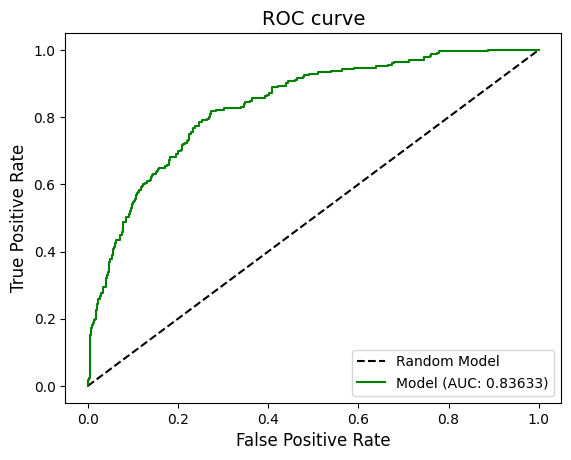

In [77]:
# Diagnosis Curva ROC
plot_auc_roc(Y,Y_pred)

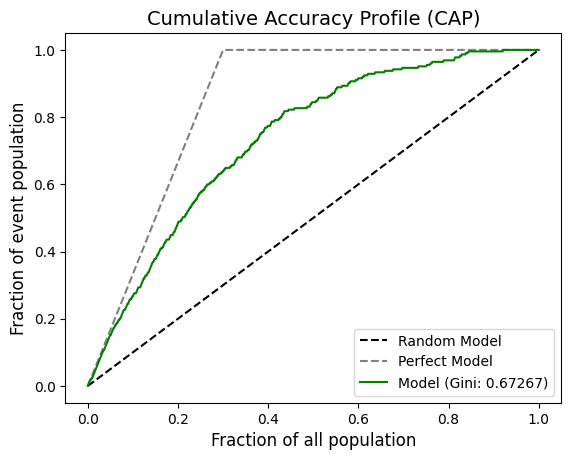

In [78]:
# Diagnosis Cumulative Accuracy Profile (CAP)

plot_cap(Y, Y_pred)

Punto de corte: 0,26

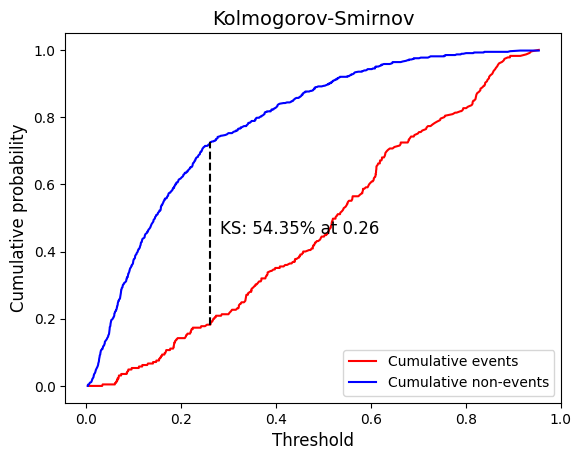

In [79]:
# Diagnosis  Plot Kolmogorov-Smirnov (KS)
plot_ks(Y, Y_pred)

In [80]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

# Calculamos la media
Y_test_pred.mean().round(5)

0.32241

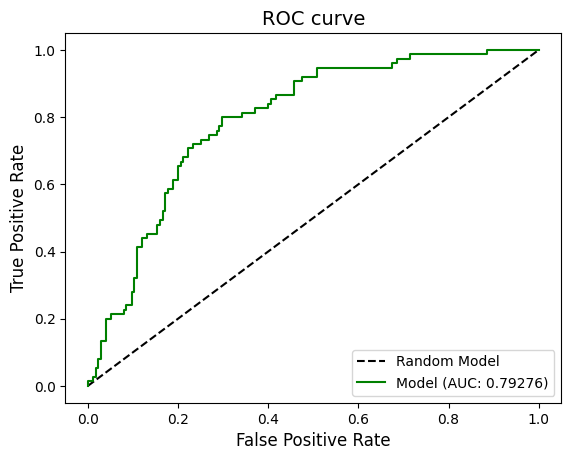

In [81]:
# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)


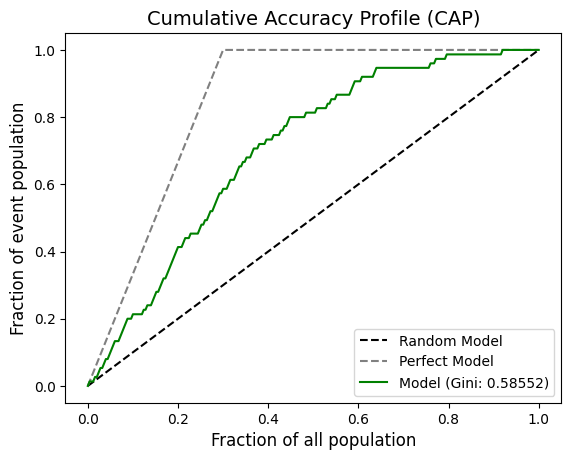

In [82]:
plot_cap(Y_test,Y_test_pred)

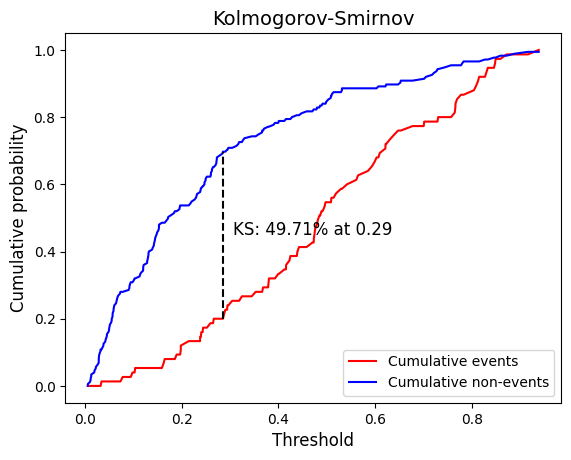

In [83]:
plot_ks(Y_test,Y_test_pred)

In [84]:
# Ahora vamos a calcular los score o puntuaciones.
#Que podemos hacer  con la función score
score = tarjeta.score(X)

print(score.min())
print(score.max())
print(score.mean())

# Transformación lineal según apuntes
# Factor= (pdo_0/log(2))
# Offset = scorecard_points_0+(pdo_0/log(2))*log(odds0_0)
# score= Offset - Factor *log(odds)

Factor= (pdo_0/np.log(2))
Offset = scorecard_points_0+Factor*np.log(1/odds_0_B)
score2= Offset-Factor*np.log(Y_pred/(1-Y_pred))

print(score2.min())
print(score2.max())
print(score2.mean())

datos_score=pd.DataFrame(np.transpose([score,score2, Y,Y_pred]), columns=['score','scoreManual','Y','Y_pred'])

# datos_score.to_excel("score_p1.xlsx")


200.25263663461163
702.2104795966648
443.975536257715
200.2526366346118
702.210479596665
443.97553625771513


Cuanto menos puntuación, mayor es la probabilidad de impago

In [85]:
datos_score.sort_values(by='scoreManual')

,score,scoreManual,Y,Y_pred
748,200.252637,200.252637,1.0,0.953250
596,218.219306,218.219306,1.0,0.937247
53,221.242397,221.242397,1.0,0.934094
301,227.905761,227.905761,1.0,0.926619
310,237.564239,237.564239,0.0,0.914394
...,...,...,...,...
326,659.959858,659.959858,0.0,0.007026
444,664.546985,664.546985,0.0,0.006493
515,695.634172,695.634172,0.0,0.003799
165,702.210480,702.210480,0.0,0.003391


Saber cómo se hace la transformación manual puede ayudarnos por ejemplo a la hora de establecer la `nota que determina el aprobado`. Imaginemos que utilizamos la frecuencia observada de impagos como probabilidad de corte 

In [86]:
Prob_Corte=Y.mean()
Score_Corte= Offset-Factor*np.log(Prob_Corte/(1-Prob_Corte))

print("La probabilida de corte de: ", Prob_Corte, " equivale a una puntuación de corte de: ", Score_Corte.round(2) )


La probabilida de corte de:  0.3  equivale a una puntuación de corte de:  423.14


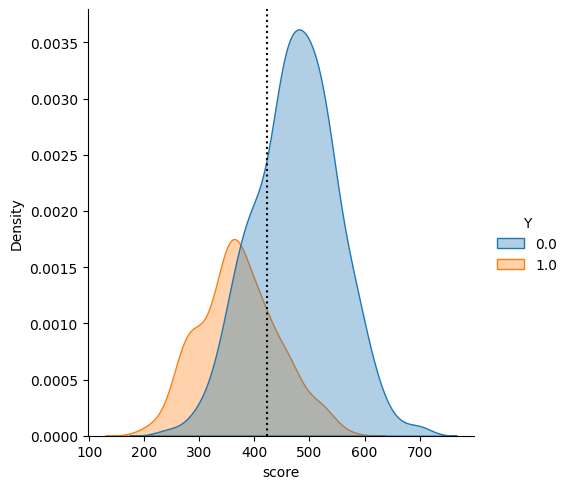

In [87]:
datos_score=pd.DataFrame(np.transpose([score,Y]), columns=['score','Y'])
sns.displot(data=datos_score, x='score', label="event", hue='Y', alpha=0.35,kind="kde", fill=True)
plt.axvline(Score_Corte, color='k', linestyle=":")

# Seguimiento del modelo: PSI (Population Stability Index)
El PSI es una medida de diferencia en la distribución de dos muestras, en nuestro caso entre la muestra utilizada para construir el modelo (entrenar y validar el modelo), y los nuevos datos que se vayan obteniendo con el transcurso del tiempo.  

Se aplica para detectar cuándo comienzan a verse diferencias entre las dos muestras (las puntuaciones de la muestra -train- y las puntuaciones obtenidas con los nuevos datos .... Cuando las distribuciones dejen de parecerse será el momento de revisar el modelo a tenor de los nuevos datos 

Como regla general 
  - **PSI <0.1**: No hay diferencias significativas entre las muestras de entrenamiento y los nuevos datos (resultado deseado, no se requiere más acciones)
  - **PSI entre 0.1 y 0.25** Hay cambio menores, valdría la pena revisar el modelo
  - **PSI >0.25** hay cambios importantes entre las dos muestras HAY QUE CAMBIAR EL MODELO 


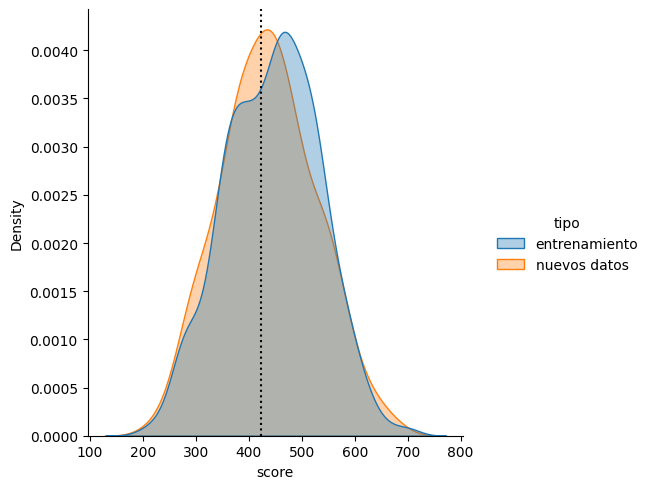

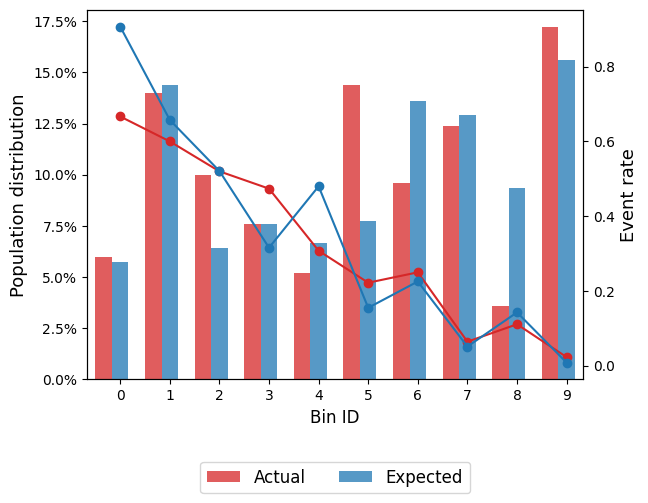

,Bin,Count A,Count E,Event rate A,Event rate E,statistic,p-value
0,"(-inf, 293.41)",15,43,0.666667,0.906977,4.898838,0.026875
1,"[293.41, 366.17)",35,108,0.600000,0.657407,0.379669,0.537780
2,"[366.17, 382.19)",25,48,0.520000,0.520833,0.000046,0.994604
3,"[382.19, 405.12)",19,57,0.473684,0.315789,1.551020,0.212985
4,"[405.12, 422.94)",13,50,0.307692,0.480000,1.240615,0.265352
5,"[422.94, 445.73)",36,58,0.222222,0.155172,0.674084,0.411631
6,"[445.73, 475.48)",24,102,0.250000,0.225490,0.065871,0.797447
7,"[475.48, 508.40)",31,97,0.064516,0.051546,0.076440,0.782181
8,"[508.40, 532.61)",9,70,0.111111,0.142857,0.067057,0.795671
9,"[532.61, inf)",43,117,0.023256,0.008547,0.551115,0.457863


In [88]:
# Supongamos que tenemos un conjunto de nuevos datos que hemos ido recopilando después de la puesta en producción del modelo,
# y queremos utilizar esos nuevos datos para saber si es necesario revisar el modelo o si por el contrario podemos seguir utilizándolo

# Como en la base de datos no disponemos de este tipo de datos voy a suponer simplemente que los datos de test son los nuevos datos,

dt_nuevosdatos= dt_test.copy() 


from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks,ScorecardMonitoring

# Defino la tarjeta a evalear
psi=ScorecardMonitoring(tarjeta, psi_method="cart",psi_n_bins=10)

# Valores nuevos
Y_nuevo = dt_nuevosdatos['y'].values
X_nuevo = dt_nuevosdatos.drop(columns=['y']) #todas menos la primera que es el ID y la variable y

# Valores de entrenamiento
Y = dt_train['y'].values
X = dt_train.drop(columns=['Unnamed: 0','y']) #todas menos la primera que es el ID y la variable y


# ¿se distibuyen igual las probabilidades esperadas?
score_train = tarjeta.score(X)
score_nuevo = tarjeta.score(X_nuevo)

datos_score_psi1=pd.DataFrame(np.transpose([score_train,Y]), columns=['score','Y'])
datos_score_psi1['tipo']='entrenamiento'

datos_score_psi2=pd.DataFrame(np.transpose([score_nuevo,Y_nuevo]), columns=['score','Y'])
datos_score_psi2['tipo']='nuevos datos'

datos_score_psi= pd.concat([datos_score_psi1,datos_score_psi2])
sns.displot(data=datos_score_psi, x='score', label="event", hue='tipo', alpha=0.35,kind="kde", fill=True,common_norm=False)
plt.axvline(Score_Corte, color='k', linestyle=":")




# Estimo el psi

psi.fit(X_actual=X_test, y_actual=Y_test, X_expected=X, y_expected=Y)

psi.psi_plot()
psi.psi_table()
psi.tests_table()


In [89]:
psi.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.1317 (Requires investigation)

         PSI bin  Count  Count (%)
    [0.00, 0.10)     10        1.0
    [0.10, 0.25)      0        0.0
    [0.25, Inf+)      0        0.0

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      1        0.1
    [0.05, 0.10)      0        0.0
    [0.10, 0.50)      4        0.4
    [0.50, 1.00)      5        0.5

  Target analysis

               Metric  Actual Actual (%)  Expected Expected (%)
    Number of records     250          -       750            -
        Event records      75        0.3       225          0.3
    Non-event records     175        0.7       525          0.7

  Performance metrics

                 Metric   Actual  Expected  Diff A - E
     True positive rate 0.453333  0.555556   -0.102222
     True negative rate 0.85

In [90]:
psi.psi_variable_table(style="summary").sort_values('PSI')

,Variable,PSI
7,other.installment.plans,0.000047
6,other.debtors.or.guarantors,0.002435
8,present.employment.since,0.002666
1,credit.amount,0.005290
12,status.of.existing.checking.account,0.010448
2,credit.history,0.012226
9,property,0.012647
11,savings.account.and.bonds,0.014369
4,housing,0.015817
10,purpose,0.026675
